In [1]:
import pandas as pd

ts_df = pd.read_csv("../data/processed/ts_features.csv", parse_dates=['Date'], index_col='Date')


In [2]:
train = ts_df.iloc[:-12].copy()
test = ts_df.iloc[-12:].copy()


In [3]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)


Train shape: (131, 26)
Test shape: (12, 26)


In [4]:
test['naive_forecast'] = train['Weekly_Sales'].iloc[-1]


In [5]:
from sklearn.metrics import mean_absolute_error

mae_naive = mean_absolute_error(test['Weekly_Sales'], test['naive_forecast'])
print("Naive Forecast MAE:", mae_naive)


Naive Forecast MAE: 3413.3833333333328


In [6]:
test['seasonal_naive'] = train['Weekly_Sales'].iloc[-52:].values[:12]
mae_seasonal = mean_absolute_error(test['Weekly_Sales'], test['seasonal_naive'])
print("Seasonal Naive MAE:", mae_seasonal)


Seasonal Naive MAE: 1456.2783333333336


In [7]:
baseline_eval = pd.DataFrame({
    'MAE': [mae_naive, mae_seasonal],
    'Model': ['Naive', 'Seasonal Naive']
})
baseline_eval.to_csv("../outputs/baseline_comparison.csv", index=False)


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error


In [9]:
ts_df = pd.read_csv("../data/processed/ts_features.csv", parse_dates=['Date'], index_col='Date')

train = ts_df.iloc[:-12].copy()
test = ts_df.iloc[-12:].copy()


In [10]:
arima_model = ARIMA(train['Weekly_Sales'], order=(1,1,1))
arima_fit = arima_model.fit()


c:\Users\VEDANT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\VEDANT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\VEDANT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


In [11]:
forecast = arima_fit.forecast(steps=12)


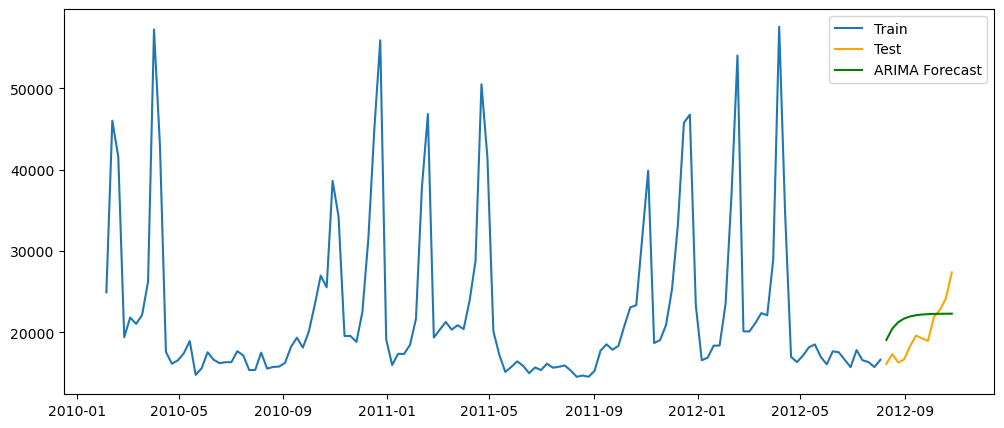

In [12]:
plt.figure(figsize=(12,5))
plt.plot(train.index, train['Weekly_Sales'], label='Train')
plt.plot(test.index, test['Weekly_Sales'], label='Test', color='orange')
plt.plot(test.index, forecast, label='ARIMA Forecast', color='green')
plt.legend()
plt.show()


In [13]:
mae_arima = mean_absolute_error(test['Weekly_Sales'], forecast)
print("ARIMA MAE:", mae_arima)


ARIMA MAE: 3022.966822340502


In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(train['Weekly_Sales'], order=(1,1,1), seasonal_order=(1,1,1,52))
sarima_fit = sarima_model.fit(disp=False)

sarima_forecast = sarima_fit.forecast(steps=12)
mae_sarima = mean_absolute_error(test['Weekly_Sales'], sarima_forecast)
print("SARIMA MAE:", mae_sarima)


c:\Users\VEDANT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\VEDANT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\VEDANT\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA MAE: 1176.3628008829535


In [15]:
classical_eval = pd.DataFrame({
    'Model': ['ARIMA', 'SARIMA'],
    'MAE': [mae_arima, mae_sarima]
})
classical_eval.to_csv("../outputs/classical_model_eval.csv", index=False)


In [16]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error


In [17]:
import pandas as pd
ts_df = pd.read_csv("../data/processed/ts_features.csv", parse_dates=['Date'], index_col='Date')


In [18]:
train = ts_df.iloc[:-12].copy()
test = ts_df.iloc[-12:].copy()


In [23]:
feature_cols = [col for col in ts_df.columns if col not in ['Weekly_Sales', 'trend', 'seasonal', 'residual']]
target_col = 'Weekly_Sales'

X_train = train[feature_cols]
y_train = train[target_col]

X_test = test[feature_cols]
y_test = test[target_col]
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

X_test = X_test.fillna(method='ffill')  # forward fill remaining NaNs in test
y_test = y_test.loc[X_test.index]



C:\Users\VEDANT\AppData\Local\Temp\ipykernel_8360\717044551.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_test = X_test.fillna(method='ffill')  # forward fill remaining NaNs in test


In [24]:
rf_model = RandomForestRegressor(n_estimators=500, random_state=42)
rf_model.fit(X_train, y_train)
rf_forecast = rf_model.predict(X_test)


In [25]:
mae_rf = mean_absolute_error(y_test, rf_forecast)
print("Random Forest MAE:", mae_rf)


Random Forest MAE: 168.14635666667314


In [26]:
gb_model = GradientBoostingRegressor(n_estimators=500, learning_rate=0.05, random_state=42)
gb_model.fit(X_train, y_train)
gb_forecast = gb_model.predict(X_test)

mae_gb = mean_absolute_error(y_test, gb_forecast)
print("Gradient Boosting MAE:", mae_gb)


Gradient Boosting MAE: 124.1305550875345


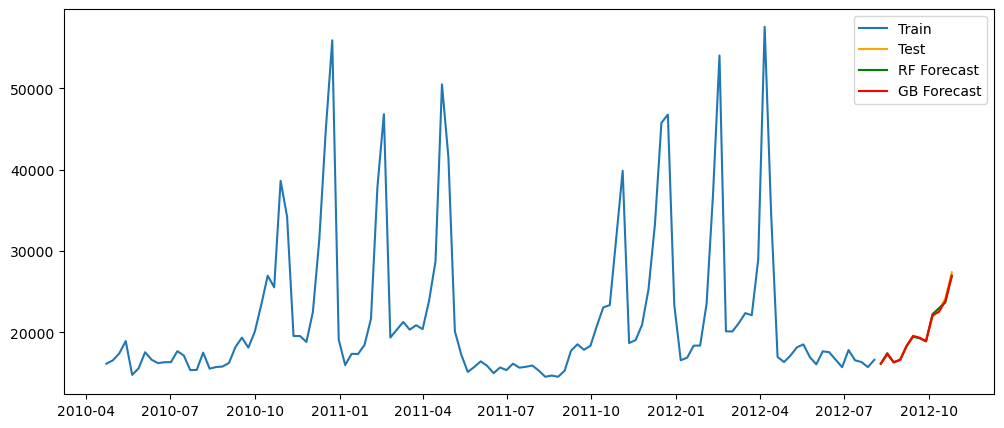

In [28]:
plt.figure(figsize=(12,5))

# Use cleaned indices
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test', color='orange')
plt.plot(y_test.index, rf_forecast, label='RF Forecast', color='green')
plt.plot(y_test.index, gb_forecast, label='GB Forecast', color='red')

plt.legend()
plt.show()



In [29]:
ml_eval = pd.DataFrame({
    'Model': ['Random Forest', 'Gradient Boosting'],
    'MAE': [mae_rf, mae_gb]
})
ml_eval.to_csv("../outputs/ml_model_eval.csv", index=False)

# Optional: save forecasts
test['rf_forecast'] = rf_forecast
test['gb_forecast'] = gb_forecast
test.to_csv("../outputs/ml_forecasts.csv")


In [30]:
import pandas as pd

comparison = pd.DataFrame({
    'Model': ['Naive', 'Seasonal Naive', 'ARIMA', 'SARIMA', 'Random Forest', 'Gradient Boosting'],
    'MAE': [mae_naive, mae_seasonal, mae_arima, mae_sarima, mae_rf, mae_gb]
})

comparison.sort_values('MAE', inplace=True)
comparison.reset_index(drop=True, inplace=True)
comparison


,Model,MAE
0,Gradient Boosting,124.130555
1,Random Forest,168.146357
2,SARIMA,1176.362801
3,Seasonal Naive,1456.278333
4,ARIMA,3022.966822
5,Naive,3413.383333


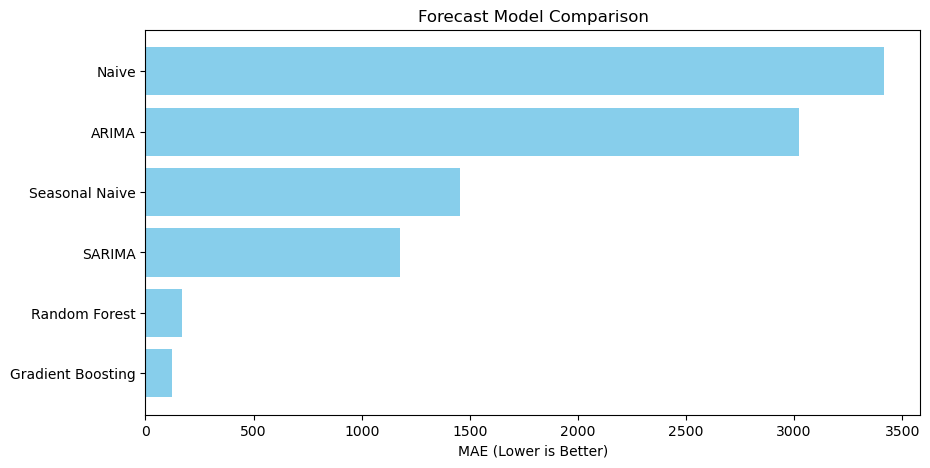

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.barh(comparison['Model'], comparison['MAE'], color='skyblue')
plt.xlabel('MAE (Lower is Better)')
plt.title('Forecast Model Comparison')
plt.show()


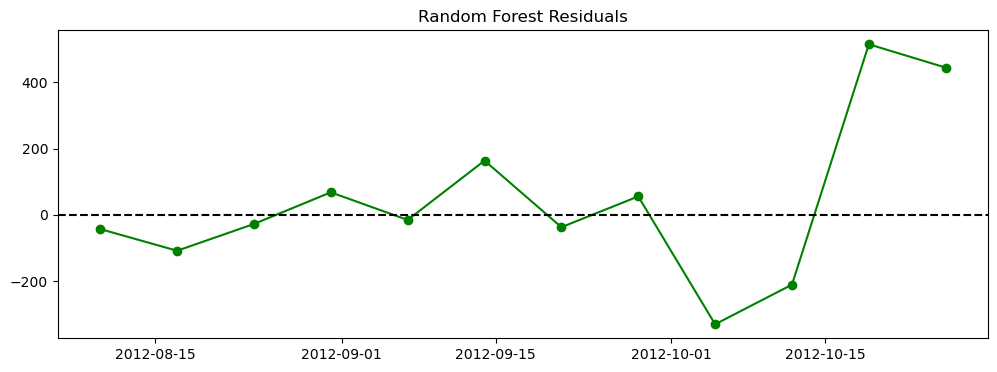

In [32]:
# Example: Random Forest residuals
rf_residuals = y_test - rf_forecast

plt.figure(figsize=(12,4))
plt.plot(rf_residuals, marker='o', linestyle='-', color='green')
plt.axhline(0, color='black', linestyle='--')
plt.title('Random Forest Residuals')
plt.show()


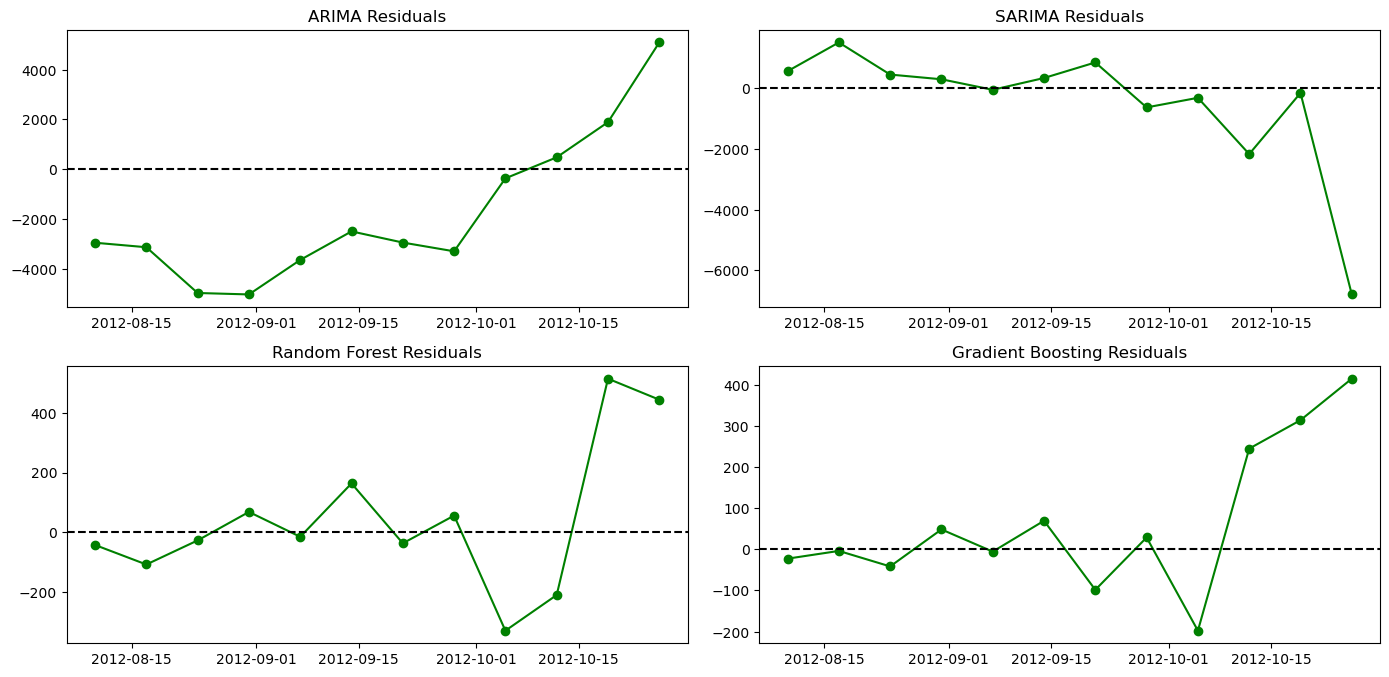

In [35]:
import matplotlib.pyplot as plt

# Calculate residuals
residuals = {
    'ARIMA': y_test - forecast,             # forecast from ARIMA
    'SARIMA': y_test - sarima_forecast,     # forecast from SARIMA
    'Random Forest': y_test - rf_forecast,
    'Gradient Boosting': y_test - gb_forecast
}

# Plot residuals
plt.figure(figsize=(14,10))

for i, (model, res) in enumerate(residuals.items(), 1):
    plt.subplot(3,2,i)
    plt.plot(res, marker='o', linestyle='-', color='green')
    plt.axhline(0, color='black', linestyle='--')
    plt.title(f'{model} Residuals')
    plt.tight_layout()

plt.show()


In [36]:
comparison.to_csv("../outputs/final_model_comparison.csv", index=False)


In [42]:
print(residuals.keys())

dict_keys(['ARIMA', 'SARIMA', 'Random Forest', 'Gradient Boosting'])


In [43]:
models = [ 'ARIMA', 'Random Forest', 'Gradient Boosting', 'SARIMA']

for model_name in models:
    res = residuals[model_name]  # dictionary from Step 11
    plt.figure(figsize=(12,4))
    plt.plot(res, marker='o', linestyle='-', color='green')
    plt.axhline(0, color='black', linestyle='--')
    plt.title(f'{model_name} Residuals')
    
    # Save each
    plt.savefig(f"../outputs/figures/{model_name}_residuals.png", dpi=300)
    plt.close()
